In [1]:
# pip install ipympl
%matplotlib widget
from logparser import get_events_from
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np

In [8]:
def plot_gc(events):
    def heap_limit(instruction_number):
        index = np.searchsorted(time_threshold, instruction_number, 'right')
        return np.array(threshold)[index-1]

    minor = [event for event in events if event["task"] == "gc-minor"]
    memory_used = [event["total-memory-used"] for event in minor]
    
    t_minor_start = np.array([int(event["start"], 16)  for event in minor], dtype=float)
    start_instruction = t_minor_start[0]
    t_minor_start -= start_instruction

    time_threshold , threshold, begin_major_gc, end_major_gc = [], [], [],[]
    for event in events:
        if event["task"] == "gc-collect-done":
            time_threshold.append(int(event["start"], 16) - start_instruction)
            threshold.append(event["new-threshold"])
    
        elif "FINALIZING" in event["text"]:
            end_major_gc.append(int(event["end"], 16) - start_instruction)
        # assumption: SCANNING only in start and final event
        elif event["task"] == "gc-collect-step" and "SCANNING" in event["text"]:
            begin_major_gc.append(int(event["start"], 16) - start_instruction)
    
    t_threshold = np.linspace(time_threshold[0], t_minor_start[-1], 300)
    y_threshold = heap_limit(t_threshold)
    plt.figure()
    plt.plot(t_minor_start,memory_used, 'b-', label="heap usage (only minor gc)")
    plt.plot(t_threshold, y_threshold, 'm', label="heap limit")
    for i in range(len(begin_major_gc)-1):
        plt.axvspan(begin_major_gc[i], end_major_gc[i], alpha=0.3, color='red')
    plt.axvspan(begin_major_gc[-1], end_major_gc[-1], alpha=0.3, color='red', label="major gc")
    plt.grid()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(EngFormatter("B"))
    ax.xaxis.set_major_formatter(EngFormatter())
    plt.xlabel("instruction number")
    plt.ylabel("memory (1 KB = 1000 B)")
    plt.title("gc-bench")
    plt.legend()
    plt.show()

In [13]:
def plot_gc_time(events):
    minor = [event for event in events if event["task"] == "gc-minor"]
    time_minor_distance = [event["time-last-minor-gc"] for event in minor]
    memory_used = [event["total-memory-used"] for event in minor]
    acc = 0
    time_minor = [0]
    for time_dist in time_minor_distance[1:]:
        acc += time_dist
        time_minor.append(acc)
    plt.figure()
    plt.plot(time_minor,memory_used, 'o-')
    plt.title("y: heap usage (only minor gc), x: time")
    plt.show()

In [16]:
gcbench_events = get_events_from("logs/gcbench")
#minor = [event for event in gcbench_events if event["task"] == "gc-minor"]
#major = [event for event in events if event["task"] == "gc-collect-step"]
#both = [event for event in events if event["task"] == "gc-minor" or event["task"] == "gc-collect-step"]
#plot_gc_time(gcbench_events)

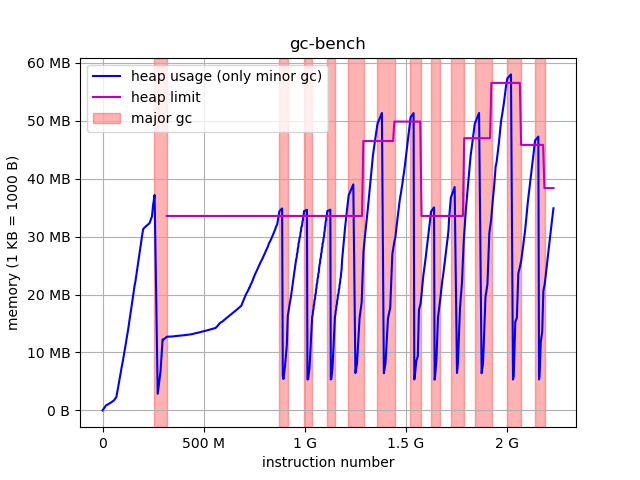

In [15]:
plot_gc(gcbench_events)